# Testing the light profile : _starlet_ decomposition

In [1]:
import os
import sys
import time
import PIL
import pysap
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

from lenstronomy.LightModel.Profiles.starlets import Starlets
import lenstronomy.Util.util as lenstro_util

from MuSLIT.utils.plot import nice_colorbar

%matplotlib inline

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

0.0 0.9333294702413144


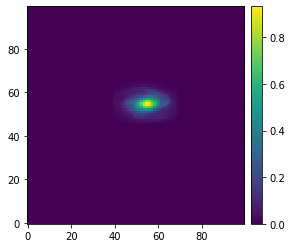

In [3]:
image = pyfits.open('data/various/M81_HST_prepared_n100.fits')[0].data
image[image < 0] = 0.
print(image.min(), image.max())

im = plt.imshow(image, origin='lower')
nice_colorbar(im)
plt.show()

## Decompose and decompose an image with starlet transform

In [4]:
starlet_profile = Starlets(thread_count=8, fast_inverse=True, second_gen=False)

### Decompose image into starlet coefficients

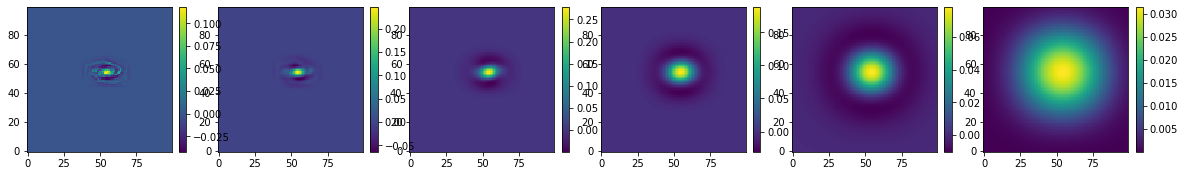

In [5]:
x, y = None, None  # normally out the coordinates grid here, not used for this profile
n_scales = 6
coeffs = starlet_profile.decomposition_2d(image, n_scales=n_scales)

fig, axes = plt.subplots(1, n_scales, figsize=(20, 4))
for i in range(coeffs.shape[0]):
    im = axes[i].imshow(coeffs[i, :, :], origin='lower')
    nice_colorbar(im)
plt.show()

### Reconcstruct image from starlet coefficients

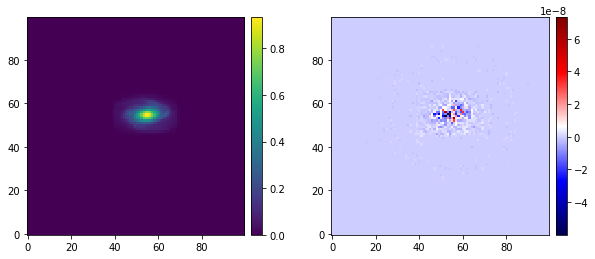

In [6]:
n_pixels = image.size
x_grid, y_grid = lenstro_util.make_grid(numPix=len(image), deltapix=1)
image_recon = starlet_profile.function(x_grid, y_grid, amp=coeffs, scale=1, 
                                       n_scales=n_scales, n_pixels=n_pixels,
                                       center_x=0, center_y=0)
image_recon = lenstro_util.array2image(image_recon)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
im = axes[0].imshow(image_recon, origin='lower')
nice_colorbar(im)
im = axes[1].imshow(image-image_recon, origin='lower', cmap='seismic')
nice_colorbar(im)
plt.show()

## Timing multithreading with pySAP

In [7]:
starlet_serial = Starlets(thread_count=1)
starlet_multithread = Starlets(thread_count=8)

In [8]:
%%timeit
coeffs = starlet_serial.decomposition_2d(image, n_scales=10)
image_r = starlet_serial.function_2d(coeffs, n_scales=10, n_pixels=image.size)

2.23 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%%timeit
coeffs = starlet_multithread.decomposition_2d(image, n_scales=10)
image_r = starlet_multithread.function_2d(coeffs, n_scales=10, n_pixels=image.size)

720 µs ± 37.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
